# CLIP-Cues: Synthetic Image Detection - Inference Example

This notebook demonstrates how to use pre-trained CLIP-Cues models to detect synthetic (AI-generated) images.

## Overview

We'll cover:
1. Loading a pre-trained model
2. Running inference on sample images
3. Interpreting the results

You can use either:
- **CLIP Orthogonal models**: Fast, accurate detection with activation orthogonality regularization
- **Concept Bottleneck models**: Interpretable predictions using human-readable concepts

## Setup

First, install the required package if you haven't already:

```bash
pip install clip-cues
```

In [6]:
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt
import torch

from clip_cues import (
    SyntheticImageClassifierInference,
    CLIPLargePatch14,
    ActivationOrthogonalityHead,
)
from clip_cues.transforms import Transforms

## Load Feature Extractor and Transforms

We use CLIP ViT-L/14 as the feature extractor, frozen to preserve its pre-trained vision-language knowledge.

In [2]:
# Load CLIP feature extractor
extractor = CLIPLargePatch14(cache_dir="../hf_cache")
extractor.freeze()

# Setup image transforms
transforms = Transforms(extractor.transforms)
inference_transforms = transforms.get_inference_transforms()

print(f"Feature extractor output dimension: {extractor.output_dim}")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Feature extractor output dimension: 1024


## Load Classification Head

The classification head is a lightweight network trained on top of frozen CLIP features.

In [3]:
# Initialize the classification head
head = ActivationOrthogonalityHead(
    input_dim=extractor.output_dim,  # 1024 for CLIP ViT-L/14
    layer_dims=[8],  # Single hidden layer with 8 neurons
    loss_weight_ortho=0.33,  # Orthogonality regularization weight
)

print(f"Classification head architecture: {extractor.output_dim} -> 8 -> 1")

Classification head architecture: 1024 -> 8 -> 1


## Create Inference Model and Load Weights

Available pre-trained models:
- `clip_orthogonal_cnnspot.ckpt` - Trained on CNNSpot dataset
- `clip_orthogonal_synthbuster.ckpt` - Trained on SynthBuster+ dataset
- `clip_orthogonal_synthclic.ckpt` - Trained on SynthCLIC dataset
- `clip_orthogonal_combined.ckpt` - Trained on combined datasets

In [12]:
# Create the full inference model
model = SyntheticImageClassifierInference(extractor.model, head)

# Load pre-trained weights
checkpoint_path = "../data/checkpoints/clip_orthogonal_combined.ckpt"

# Check if checkpoint exists
if Path(checkpoint_path).exists():
    checkpoint = torch.load(checkpoint_path, weights_only=True)

    # Remove "model." prefix from state dict keys
    weights = {k.replace("model.", ""): v for k, v in checkpoint["state_dict"].items()}

    # Load weights
    model.load_state_dict(weights, strict=False)
    print("✓ Pre-trained weights loaded successfully")
else:
    print(f"⚠ Checkpoint not found at {checkpoint_path}")
    print("Please download pre-trained checkpoints from the repository")

# Set model to evaluation mode
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model running on: {device}")

✓ Pre-trained weights loaded successfully
Model running on: cuda


## Inference on a Single Image

Let's test the model on a sample image.

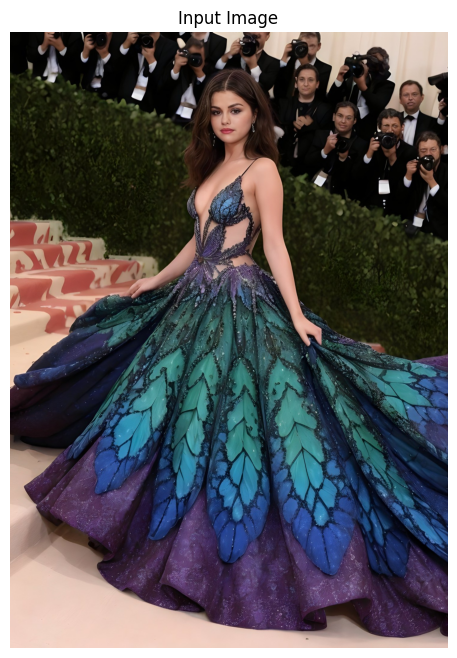


Prediction Results
Synthetic probability: 0.696
Real probability:      0.304

Prediction: SYNTHETIC
Confidence: 69.6%


In [13]:
# Load an image (replace with your own image path)
image_path = "../examples/images/synthetic2.jpg"

if Path(image_path).exists():
    # Load and display the image
    image = Image.open(image_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    # Prepare the image for inference
    batch = inference_transforms({"image": [image]})
    pixel_values = torch.stack(batch["pixel_values"]).to(device)

    # Run inference
    with torch.no_grad():
        prob = model(pixel_values)

    # Display results
    synthetic_prob = prob.item()
    real_prob = 1 - synthetic_prob

    print(f"\n{'='*50}")
    print(f"Prediction Results")
    print(f"{'='*50}")
    print(f"Synthetic probability: {synthetic_prob:.3f}")
    print(f"Real probability:      {real_prob:.3f}")
    print(f"\nPrediction: {'SYNTHETIC' if synthetic_prob > 0.5 else 'REAL'}")
    print(f"Confidence: {max(synthetic_prob, real_prob):.1%}")
    print(f"{'='*50}")
else:
    print(f"⚠ Image not found at {image_path}")
    print("Please provide a valid image path")

## Batch Inference on Multiple Images

Process multiple images at once for efficiency.

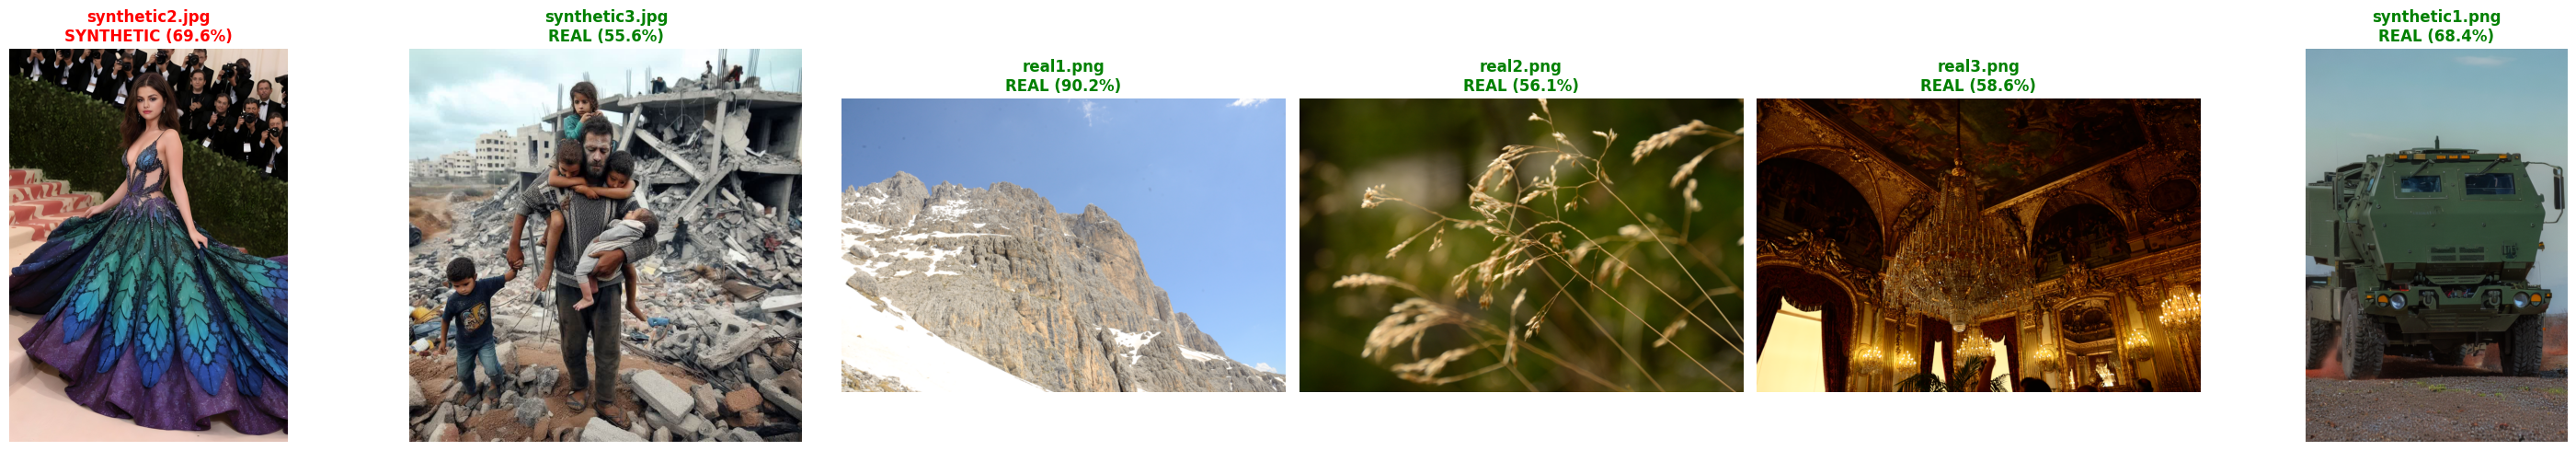


Detailed Results:
synthetic2.jpg                 | Synthetic: 0.696 | SYNTHETIC
synthetic3.jpg                 | Synthetic: 0.444 | REAL     
real1.png                      | Synthetic: 0.098 | REAL     
real2.png                      | Synthetic: 0.439 | REAL     
real3.png                      | Synthetic: 0.414 | REAL     
synthetic1.png                 | Synthetic: 0.316 | REAL     


In [14]:
# Example: Process multiple images from a directory
image_dir = Path("../examples/images/")

if image_dir.exists():
    # Load all images
    image_paths = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

    if image_paths:
        images = [Image.open(p) for p in image_paths]

        # Transform all images
        batch = inference_transforms({"image": images})
        pixel_values = torch.stack(batch["pixel_values"]).to(device)

        # Run batch inference
        with torch.no_grad():
            probs = model(pixel_values)

        # Display results
        fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))
        if len(images) == 1:
            axes = [axes]

        for idx, (img_path, img, prob) in enumerate(zip(image_paths, images, probs)):
            axes[idx].imshow(img)
            axes[idx].axis('off')

            synthetic_prob = prob.item()
            prediction = "SYNTHETIC" if synthetic_prob > 0.5 else "REAL"
            confidence = max(synthetic_prob, 1 - synthetic_prob)

            color = 'red' if prediction == "SYNTHETIC" else 'green'
            axes[idx].set_title(
                f"{img_path.name}\n{prediction} ({confidence:.1%})",
                color=color,
                fontweight='bold'
            )

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\nDetailed Results:")
        print(f"{'='*70}")
        for img_path, prob in zip(image_paths, probs):
            synthetic_prob = prob.item()
            print(f"{img_path.name:30} | Synthetic: {synthetic_prob:.3f} | {('SYNTHETIC' if synthetic_prob > 0.5 else 'REAL'):9}")
        print(f"{'='*70}")
    else:
        print("No images found in the directory")
else:
    print(f"Directory {image_dir} not found")
    print("Create a 'test_images' folder and add some images to test batch inference")

## Helper Function for Easy Inference

In [15]:
def predict_image(image_path_or_pil, threshold=0.5):
    """
    Predict whether an image is synthetic or real.

    Args:
        image_path_or_pil: Path to image file or PIL Image object
        threshold: Classification threshold (default: 0.5)

    Returns:
        dict: Prediction results with probabilities and label
    """
    # Load image if path is provided
    if isinstance(image_path_or_pil, (str, Path)):
        image = Image.open(image_path_or_pil)
    else:
        image = image_path_or_pil

    # Transform and prepare for inference
    batch = inference_transforms({"image": [image]})
    pixel_values = torch.stack(batch["pixel_values"]).to(device)

    # Run inference
    with torch.no_grad():
        prob = model(pixel_values)

    synthetic_prob = prob.item()
    real_prob = 1 - synthetic_prob

    return {
        "synthetic_probability": synthetic_prob,
        "real_probability": real_prob,
        "prediction": "synthetic" if synthetic_prob > threshold else "real",
        "confidence": max(synthetic_prob, real_prob)
    }

# Example usage
# result = predict_image("path/to/image.jpg")
# print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.1%})")

## Understanding the Results

### Output Interpretation

- **Synthetic Probability**: Value between 0 and 1 indicating likelihood the image is AI-generated
  - Close to 1.0 → Likely synthetic
  - Close to 0.0 → Likely real
  - Around 0.5 → Uncertain

- **Confidence**: The maximum of synthetic and real probabilities
  - High confidence (>0.9): Model is very certain
  - Medium confidence (0.7-0.9): Model is moderately certain
  - Low confidence (<0.7): Model is uncertain

### Model Selection Tips

- **SynthCLIC**: Best for web images and diverse generative models
- **SynthBuster+**: Good for social media images
- **CNNSpot**: Specialized for specific GAN architectures
- **Combined**: Best overall generalization across different sources

### Limitations

- Performance may vary on heavily compressed or edited images
- Model trained on specific generative models may not generalize to all new methods
- Always validate results in critical applications

## Next Steps

- Try different pre-trained checkpoints for comparison
- Explore the Concept Bottleneck models for interpretable predictions
- Fine-tune models on your own datasets
- Check the [documentation](https://github.com/marco-willi/clip-cues) for more advanced usage